In [58]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
import seaborn as sns

sns.set_context("notebook")
sns.set_style("ticks")

import jax

# by default, jax uses 32-bit precision, which is a trade off that ML people are often willing to
# make, but for most of our purposes, we want 64-bit precision
jax.config.update("jax_enable_x64", True)

# Intro to JAX

`J` - JIT

`A` - Autograd

`X` - XLA

Jax gives you three main things:
1. `JIT` - Just In Time compilation:
    - Speeds up your code
2. `Autograd` - Automatic differentiation:
    - Computes gradients of your code, with no extra effort on your part. Gradients can be useful on their own, but the real benefits come from including then in your optimization or fitting processes.
3. `XLA` - Accelerated Linear Algebra:
    - Compiles and runs code on CPU, GPUs or TPUs.


These things are all possible with languages like Julia or subsets of C++, but JAX is fully integrated with Python and provides an _almost_ drop-in replacement for numpy.




Disclaimer 1: I'm not going to talk about GPU stuff here, if you have big problems _and_ access to GPUs, you should look into it, expect orders of magnitude speedups just by switching from CPU to GPU with essentially no code changes

Disclaimer 2: I'm not an expert on JAX, I just like to sprinkle it in my code when I can. Documentation is linked at the end of this notebook and the JAX documentation is quite good and full of examples.

# JIT

Just In Time means that code is compiled as it is run. This can speed up your code significantly, especially if you are running the same code many times.

Here is an example of how you can use JIT to speed up a simple function:

Functions need to be implemented in JAX in order to be JIT compiled. This means that you need to use JAX's version of numpy functions, which are typically import as `jnp` (jax.numpy).

In [59]:
# define some arbitrary function
def plummer_dispersion(rs, sigma0, a):
    return np.sqrt(sigma0**2 / np.sqrt(1 + rs**2 / a**2))


# define the same function but with jax
# import the jax version of numpy
import jax.numpy as jnp


# now define the function in the exact same way
def plummer_dispersion_jax(rs, sigma0, a):
    return jnp.sqrt(sigma0**2 / jnp.sqrt(1 + rs**2 / a**2))


# now do some basic benchmarking

# absurd resolution, for demonstration purposes
rs = np.linspace(0, 1000, 1_000_000)

# first the numpy version
print("numpy:")
%timeit plummer_dispersion(rs, 15, 200)
print()


# now the jax version
print("jax:")
%timeit plummer_dispersion_jax(rs, 15, 200)
print()

# now turn on JIT:
plummer_dispersion_jax_jit = jax.jit(plummer_dispersion_jax)

# The first time we evaluate the function, it will be compiled
print("jax jit compilation:")
%time _ = plummer_dispersion_jax_jit(rs, 15, 200)
print()

# all subsequent calls will be faster
print("jax jitted:")
%timeit plummer_dispersion_jax_jit(rs, 15, 200)

2.3e-3 / 350e-6


numpy:
2.1 ms ± 154 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

jax:
1.23 ms ± 19.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

jax jit compilation:
CPU times: user 10.8 ms, sys: 1.43 ms, total: 12.2 ms
Wall time: 11.9 ms

jax jitted:
350 μs ± 18.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


6.571428571428571

Anything that is implemented in `numpy` can probably be implemented in JAX, though more comples functions may require more work. 

If you are doing a lot of "math stuff" in your code, you will probably be able to use JAX without too much trouble.

## Some things to be careful about: Control flow

JAX needs to be able to trace the code you want to JIT compile. This means that the behavior of your
code can't change depending on the input. Using IF statements or certain kinds of loops in your functions with cause problems
with JIT!

In [60]:
def function_with_if(x):
    if x > 0:
        return -x
    return x


print(function_with_if(5))
print(function_with_if(-5))

-5
-5


In [61]:
# try to JIT this function

jax.jit(function_with_if)(5)

# fails with a big ugly error message

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function function_with_if at /var/folders/ky/t4214cvn41x2pt7m57v3mlfrbv8h84/T/ipykernel_44342/1602498362.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [62]:
# can rewrite the same function to be more jax-friendly

def function_with_if_jax(x):
    return jnp.where(x > 0, -x, x)


print(function_with_if_jax(5))
print(jax.jit(function_with_if_jax)(-5))

-5
-5


This was a simple example of how to work around the restriction of control flow in JAX. There are more advanced ways to do this when you have a more complex function.

One common pattern is to specify "static arguments". Telling JAX that an argument is static means that the function will be recompiled if that argument changes.


In [63]:
# static_argnums example


def add_loop(starting_val, increments):
    val = starting_val
    for _ in range(increments):
        val += 1
    return val


print(add_loop(5, 10))

15


In [64]:
# try to JIT this function

jax.jit(add_loop)(5, 10)

# fails with a big ugly error message, because the behavior of the function depends on the value of the second argument

TracerIntegerConversionError: The __index__() method was called on traced array with shape int64[]
The error occurred while tracing the function add_loop at /var/folders/ky/t4214cvn41x2pt7m57v3mlfrbv8h84/T/ipykernel_44342/703288431.py:4 for jit. This concrete value was not available in Python because it depends on the value of the argument increments.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError

In [65]:
# try to JIT it again, this time specifying that the second argument is static

print(jax.jit(add_loop, static_argnums=(1))(5, 10))

# try with a different value of the second argument
print(jax.jit(add_loop, static_argnums=(1))(5, 100))

15
105


This sort of pattern is also extremely common for Class methods. In these cases you want to JAX that the `self` argument is static, so that the function is recompiled for each instance of the class.

It's very common to use the `@jax.jit` decorator to JIT functions at declaration time. This is identical to using `f = jax.jit(f)`.

```python
import jax

def f(x):
    return x * 2

f_jit = jax.jit(f)

# equivalent to:

@jax.jit
def f(x):
    return x * 2

f(3) # this is JIT'd


# can also use @partial to JIT with some arguments static
from functools import partial

@partial(jax.jit, static_argnums=(1,))
def f(x, y):
    return x * y

f(3, 2) # this is JIT'd and specifies that the second argument is static
```

# VMAP

JAX also provides a way to automatically vectorize functions. This can be useful for executing the same function on many different inputs _in parallel_. VMAP is subject to most of the same restrictions as JIT, but can get you similar speedups.


In [66]:
# Let's create a function that calculates multiple statistical properties at once
def compute_stats(x):
    # Calculate mean, standard deviation, and skewness for a single array
    mean = jnp.mean(x)
    std = jnp.std(x)
    return mean, std

# Create some test data - 50 arrays of 1000 samples each
data = jnp.array([np.random.normal(loc=i, scale=1.0, size=1000) for i in range(50)])


# Without vmap - looping over the data
print("Without vmap:")
%timeit regular_stats = jnp.array([compute_stats(x) for x in data])

# With vmap - Executes the function in parallel, all at once
print("\nWith vmap:")
vectorized_stats = jax.vmap(compute_stats)
%timeit vmap_stats = vectorized_stats(data)


Without vmap:
5.89 ms ± 19.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

With vmap:
188 μs ± 423 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


This is a bit of a contrived example, because you could have specified the indices in the original function and evaluated everything at the same time. This kind of manual broadcasting/indexing can be a bit error-prone and hard to read, so VMAP can be a useful tool for this kind of thing. The main use case for VMAP is when you have a function that you want to evaluate on many different inputs at the same time. This situaton comes up more often that you might think. Evaluating a pdf on a large multidimensional grid might be a good example of this.

# Autograd

Autograd is a way to automatically compute gradients of your code. This is useful for optimization, fitting, and many other things.

Autograd is not symbolic differentiation. It is a repeated application of the chain rule. Despite not being symbolic, it will still calculate gradients that are correct to machine precision because the analytic derivatives of the base functions are known.

Here is an example of how to use autograd to compute the gradient of a simple function:

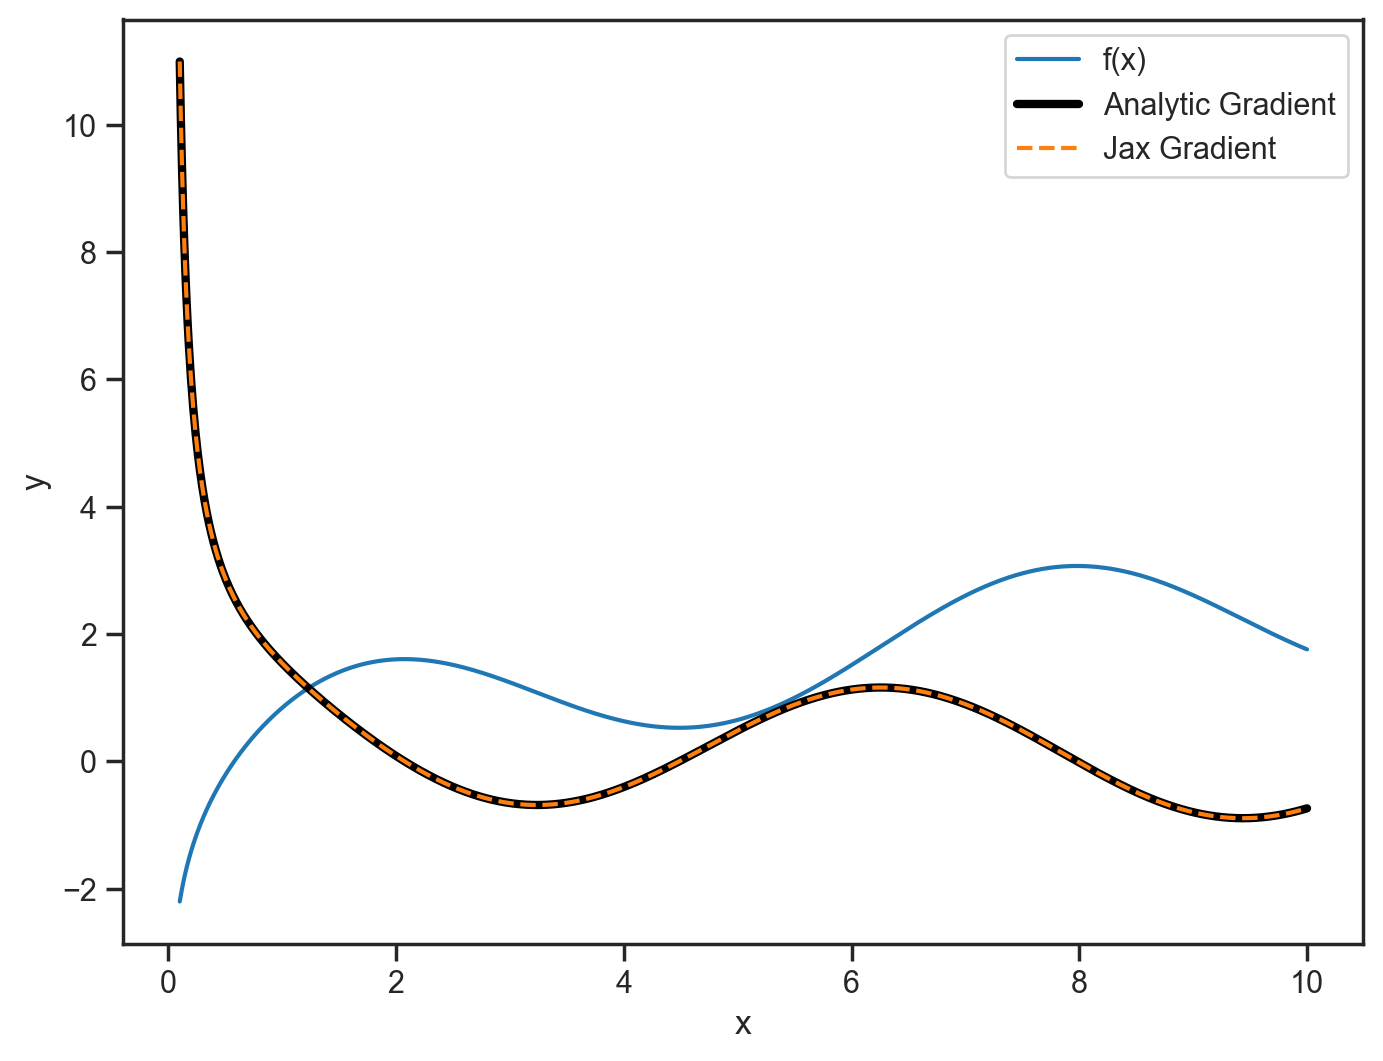

In [68]:
def function_to_diff(x):
    return jnp.sin(x) + jnp.log(x)


def analytical_derivative(x):
    return jnp.cos(x) + 1 / x


# Compute the gradient of the function using jax
grad_fn = jax.grad(function_to_diff)

xs = np.linspace(0.1, 10, 1_000)

plt.figure()


plt.plot(xs, function_to_diff(xs), label="f(x)")

plt.plot(xs, analytical_derivative(xs), label="Analytic Gradient", lw=3, color="black")

# here we use vmap to apply the gradient function to all the values in xs, grad only works on scalar
# functions (intended for things like loss functions), but see jax.jacobian for vector functions
plt.plot(xs, jax.vmap(grad_fn)(xs), label="Jax Gradient", ls="--")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

This was a pretty simple example but it also translates to more complex functions.

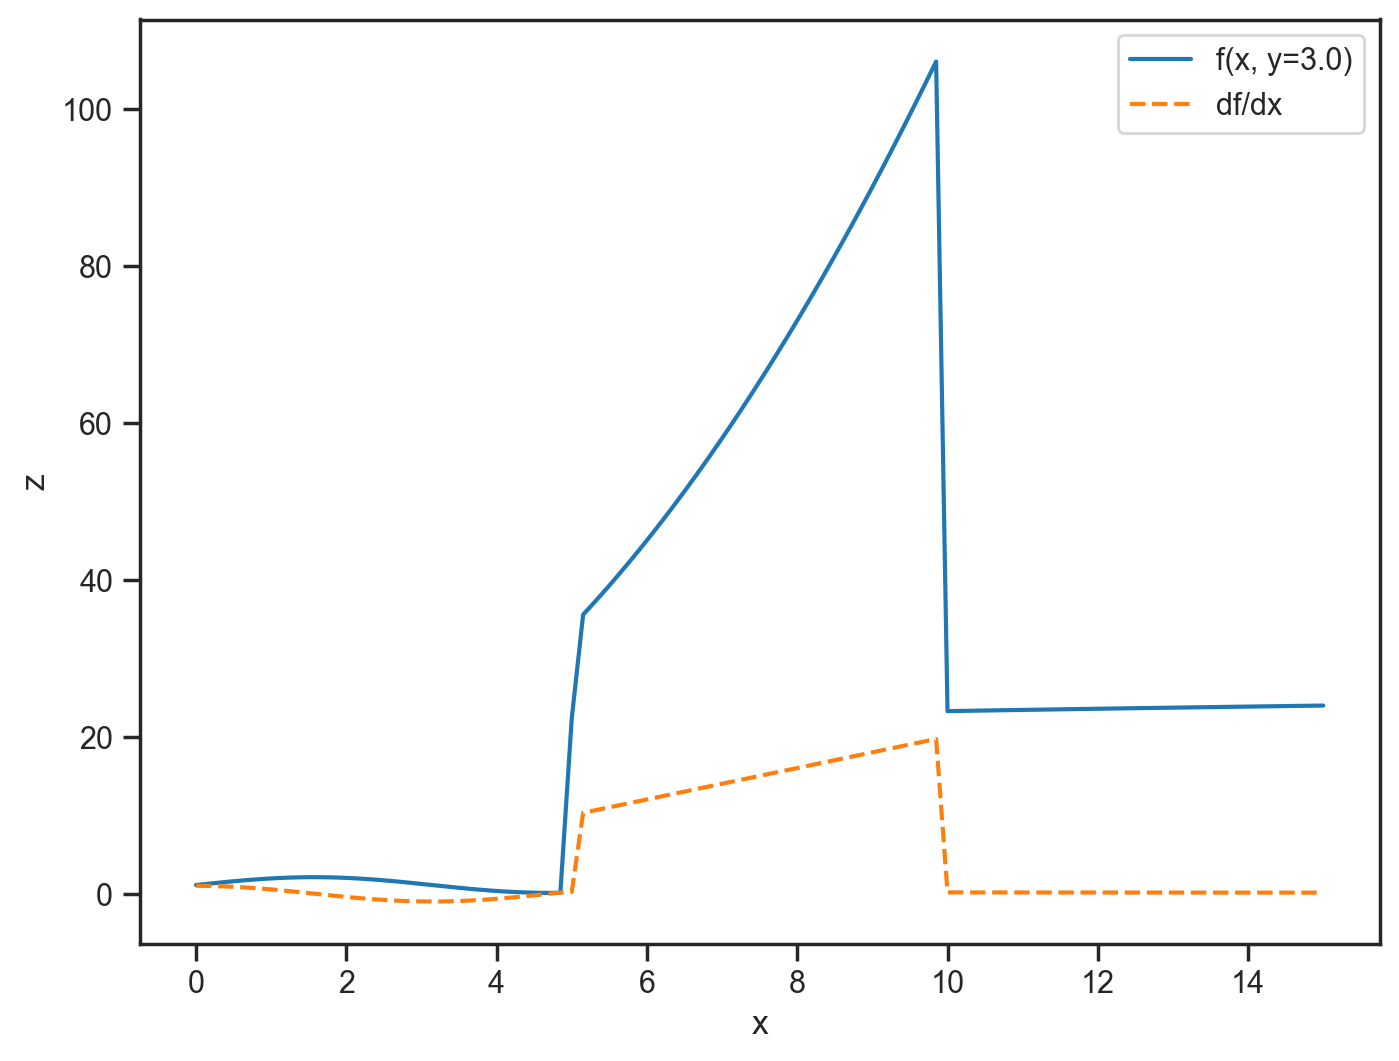

In [69]:
def difficult_function(x, y):
    # some awkward function **with control flow**
    if 5 < x < 10:
        return x**2 + y**2
    elif x < 5:
        return jnp.sin(x) + jnp.log(y)
    else:
        return jnp.sqrt(x) + jnp.exp(y)


# We can't JIT this function as it is, but we can Differentiate it!

grad_difficult_function = jax.grad(difficult_function)

xs = np.linspace(0, 15, 100)
y = 3.0

plt.figure()
plt.plot(xs, [difficult_function(x, y) for x in xs], label=f"f(x, y={y})")
plt.plot(xs, [grad_difficult_function(x, y) for x in xs], label="df/dx", ls="--")

plt.xlabel("x")
plt.ylabel("z")
plt.legend()

Notice in the above example that we didn't have any problems with control flow. Computing gradients with JAX is much more flexible than JIT compiling code.

# Combining JIT and Autograd: some more practical examples

This has all been a bit contrived, let set up an example that is a bit more realistic. Calculating the gradient of a loss function to speed up optimization.

## A quick look at how gradients help optimization

First it's worth quickly looking at why gradients are useful for optimization-style problems. In the figure below, I've created a toy likelihood function for easy visualization. This likelihood is symmetric, but also sharpely peaked. I've drawn four different points on this likelihood and we can look at each of them to see how the gradient can help us find the minimum. At the leftmost point, the gradient is positive, but small, so the optimal step would be a large positive step. At the second point, the gradient is still positive, but larger, so the optimal step would be a small positive step. At the third point, we now have a large negative gradient, so the optimal step would be a small negative step. At the rightmost point, the gradient is negative, but small, so the optimal step would be a large negative step. This is the basic idea behind gradient descent. The sign of the gradient tells you which way to go, and the magnitude of the gradient tells you how far to go.

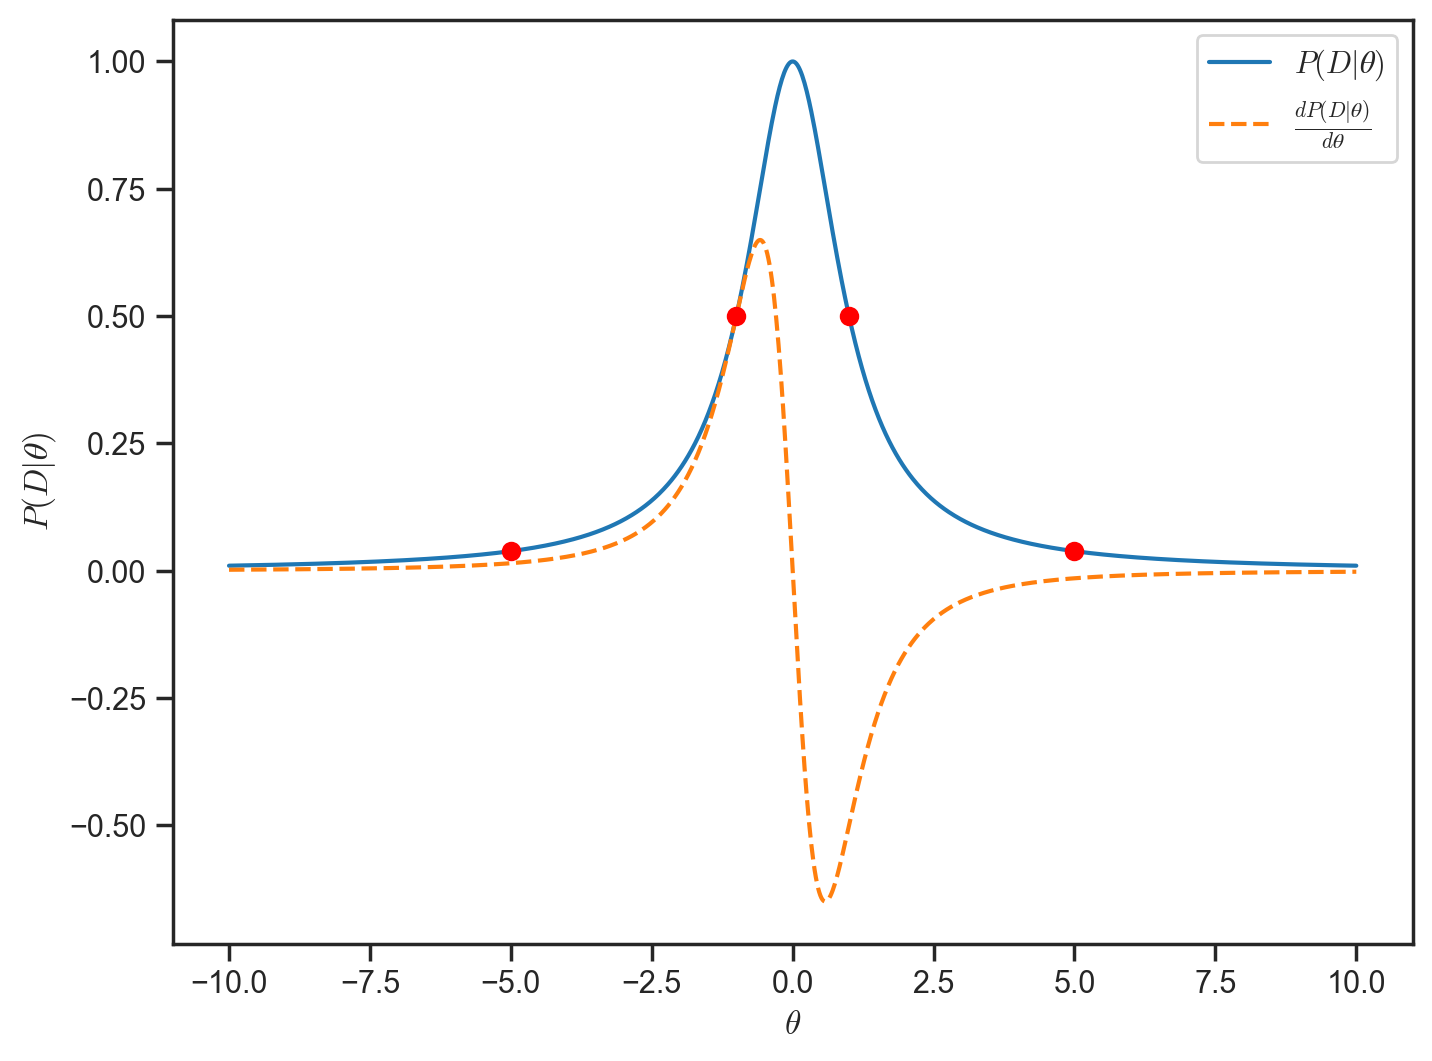

In [70]:
# draw a laurentian profile as an example likelihood function
def lorentzian(x, x0, gamma):
    return 1 / (1 + ((x - x0) / gamma)**2)

lorentzian_grad = jax.grad(lorentzian)

plt.figure()
x = np.linspace(-10, 10, 1000)
plt.plot(x, lorentzian(x, 0, 1), label=r"$P(D|θ)$")
plt.plot(x, [lorentzian_grad(x, 0, 1) for x in x], ls="--", label=r"$\frac{dP(D|θ)}{dθ}$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$P(D|θ)$")
plt.legend()

# add in some larger dots at the values of -5, -1, 1, and 5
plt.scatter([-5, -1, 1, 5], lorentzian(np.array([-5, -1, 1, 5]), 0, 1), color="red", zorder=10)


## Now apply this to a real optimization problem

Text(0, 0.5, 'y')

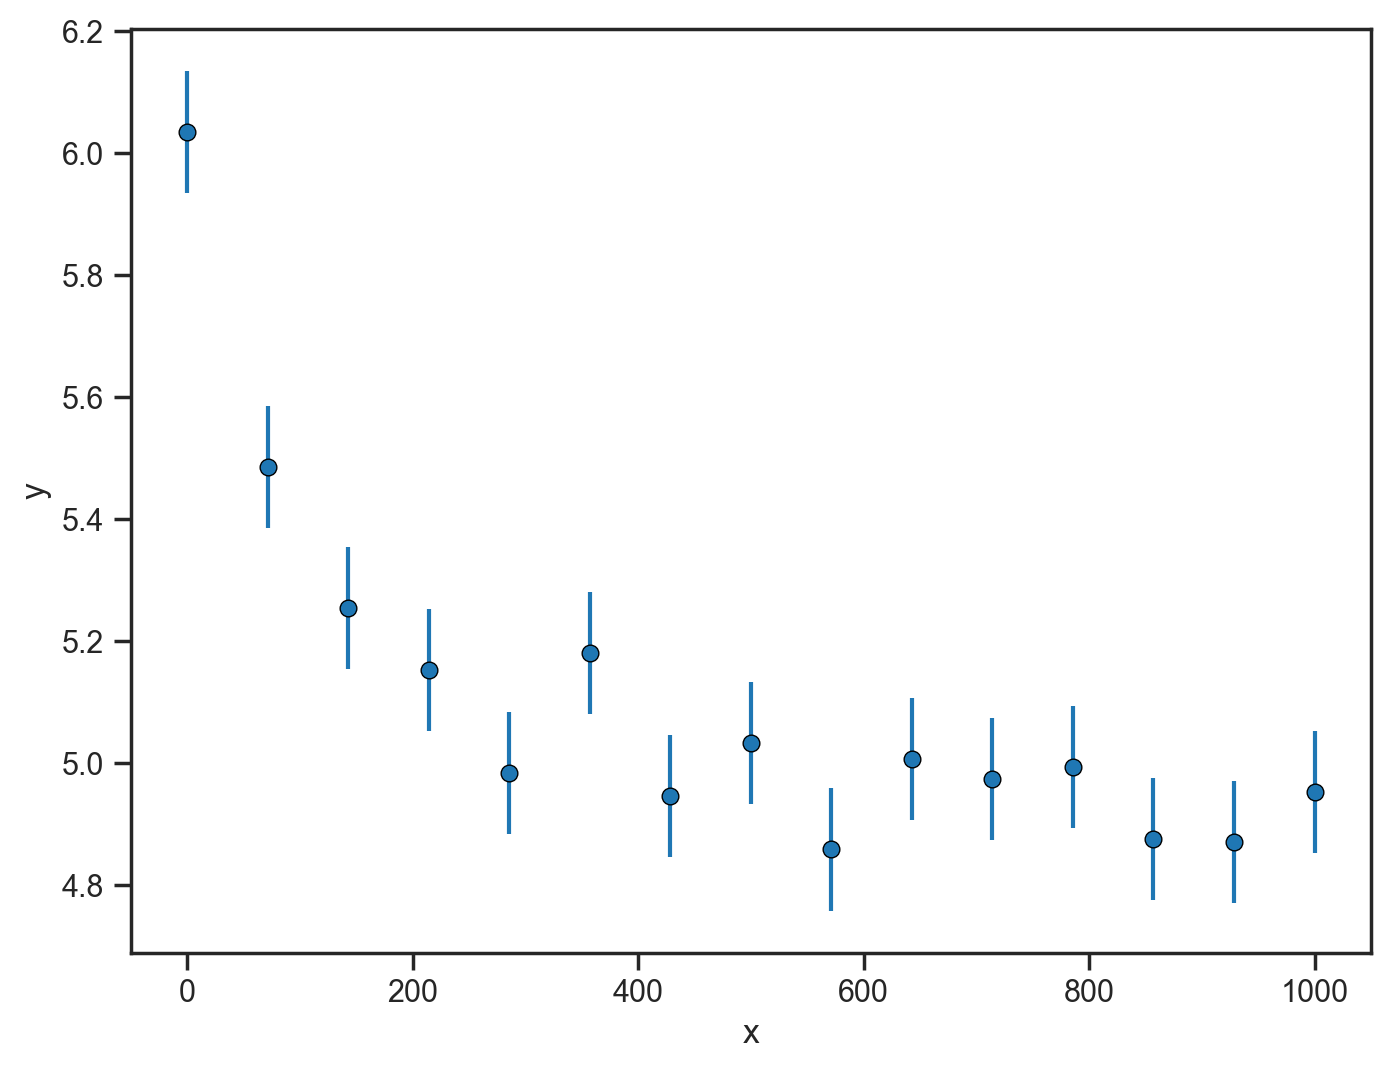

In [71]:
# set up the problem

xs = np.linspace(0.0, 1000.0, 15)


# function with some parameters, exponential decay with an offset
def exponential_decay(x, a, b, c):
    return a * jnp.exp(-x / b) + c


params = (1.0, 100.0, 5)

# generate some data
ys = exponential_decay(xs, *params)

# add some noise, here we assume the noise is known (and in this case, constant)
ys += 0.1 * np.random.randn(len(xs))

yerrs = np.ones_like(ys) * 0.1

plt.figure()
plt.errorbar(xs, ys, yerr=0.1, fmt="o", label="Data")
plt.xlabel("x")
plt.ylabel("y")

True params: (1.0, 100.0, 5)
Fit params: [  1.06295074 117.98093116   4.95117205]
Number of function evaluations: 259


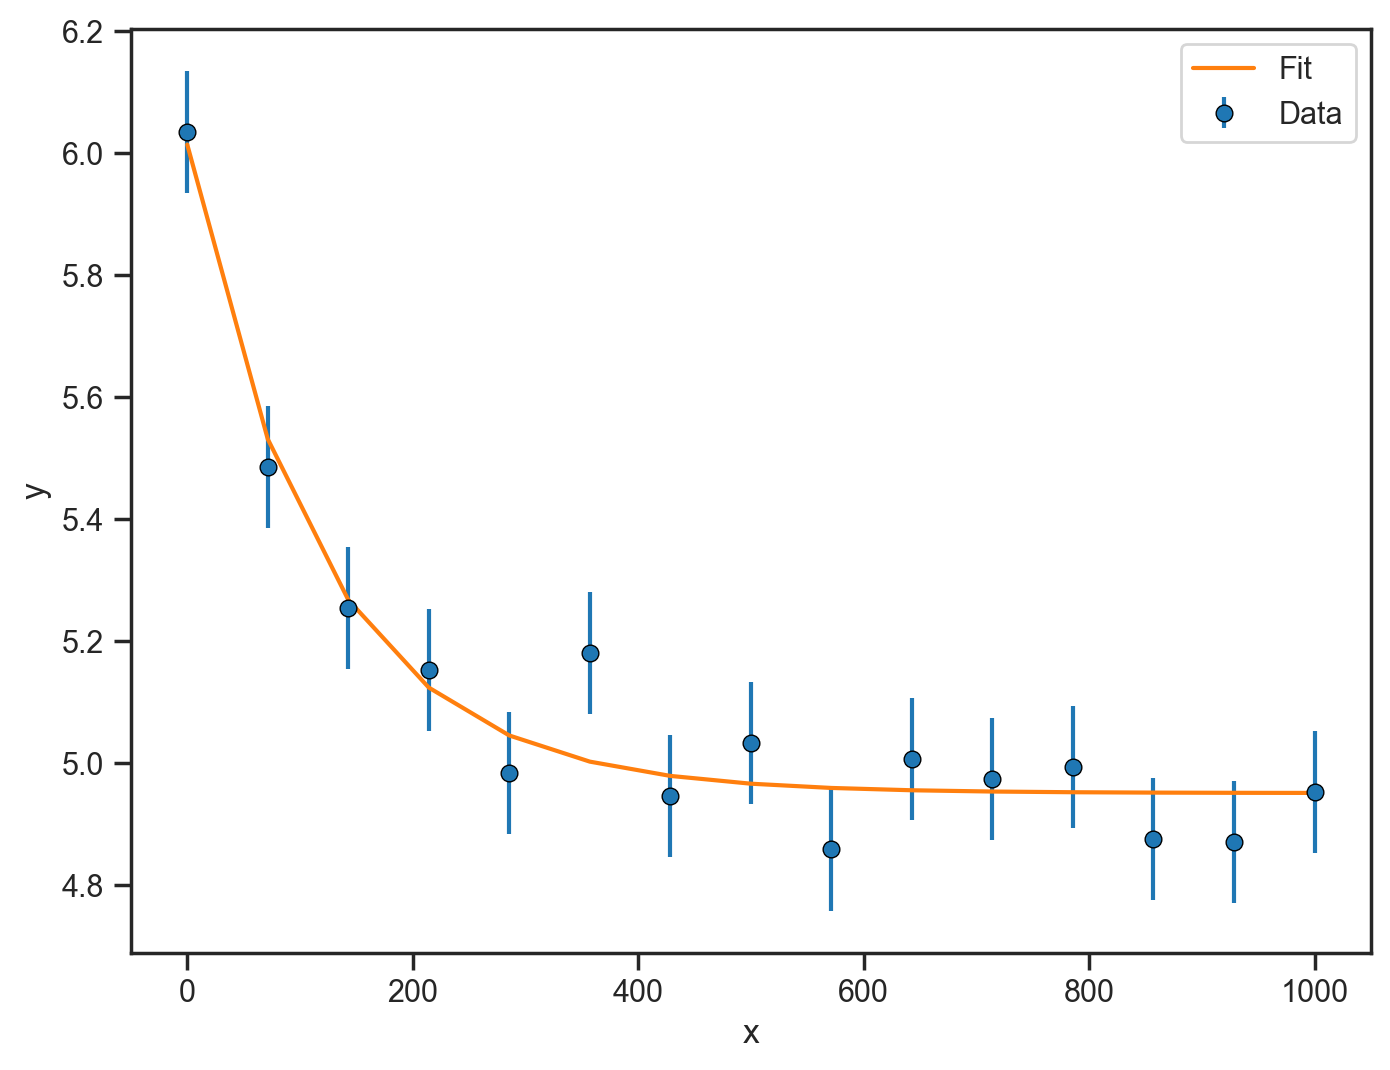

In [72]:
# set up the loss function


def nll(params, xs, ys, yerrs):
    model_ys = exponential_decay(xs, *params)
    return jnp.sum(0.5 * ((model_ys - ys) / yerrs) ** 2)


# optimize the function
from scipy.optimize import minimize

result = minimize(
    lambda params: nll(params, xs, ys, yerrs),
    x0=(5.0, 200.0, 10.0),
    tol=1e-10,
)

plt.figure()
plt.errorbar(xs, ys, yerr=0.1, fmt="o", label="Data")
plt.plot(xs, exponential_decay(xs, *result.x), label="Fit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()


print(f"True params: {params}")
print(f"Fit params: {result.x}")
print(f"Number of function evaluations: {result.nfev}")

In [73]:
# benchmark the plain nll vs a jitted version

print("nll:")
%timeit minimize(lambda params: nll(params, xs, ys, yerrs), x0=(5.0, 200.0, 10.0), tol=1e-10)

nll_jax = jax.jit(nll)
_ = nll_jax((5.0, 200.0, 10.0), xs, ys, yerrs)

print("nll JIT:")
%timeit minimize(lambda params: nll_jax(params, xs, ys, yerrs), x0=(5.0, 200.0, 10.0), tol=1e-10)

nll:
23.1 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
nll JIT:
10.7 ms ± 180 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
# the same factor of a few speedup as before

In [74]:
# now we try the same thing, but we include the gradient

jac = jax.jacobian(nll)

result = minimize(
    lambda params: nll(params, xs, ys, yerrs),
    x0=(5.0, 200.0, 10.0),
    tol=1e-10,
    jac=lambda params: jac(params, xs, ys, yerrs),
)

print(f"True params: {params}")
print(f"Fit params: {result.x}")
print(f"Number of function evaluations: {result.nfev}")
print(f"Number of gradient evaluations: {result.njev}")


True params: (1.0, 100.0, 5)
Fit params: [  1.06295063 117.98094894   4.95117211]
Number of function evaluations: 70
Number of gradient evaluations: 58


By using the gradient of the loss function, we arrive at the same answer but with many fewer function evaluations.

This can really add up if your model is slow to evaluate, or if this optimization step happens as a part of a larger iterative process.

In [75]:
# benchmark the plain nll vs a gradient version

print("nll:")
%timeit minimize(lambda params: nll(params, xs, ys, yerrs), x0=(5.0, 200.0, 10.0), tol=1e-10)

nll_jax = jax.jit(nll)
jac_jax = jax.jit(jac)

_ = nll_jax((5.0, 200.0, 10.0), xs, ys, yerrs)

print("nll Gradient:")
%timeit minimize(lambda params: nll_jax(params, xs, ys, yerrs), x0=(5.0, 200.0, 10.0), tol=1e-10)

nll:
23 ms ± 460 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
nll Gradient:
10.5 ms ± 165 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Not much of a speed up here, but our model is trivially simple. The speedup can be much more significant for more complex models where function evaluations are more expensive.

# Another practical example: fitting a velocity dispersion with MCMC

MCMC requires a ton of likelihood evaluations. If we can speed up the likelihood evaluation, we can speed up the MCMC.

Here we will just just `emcee` but because we have gradients, we could use something much fancier! I like to use `blackjax` for this sort of thing which implements HMC and NUTS samplers along with automated tuning of the sampler parameters.

In [76]:
import scipy
from astropy.stats import knuth_bin_width

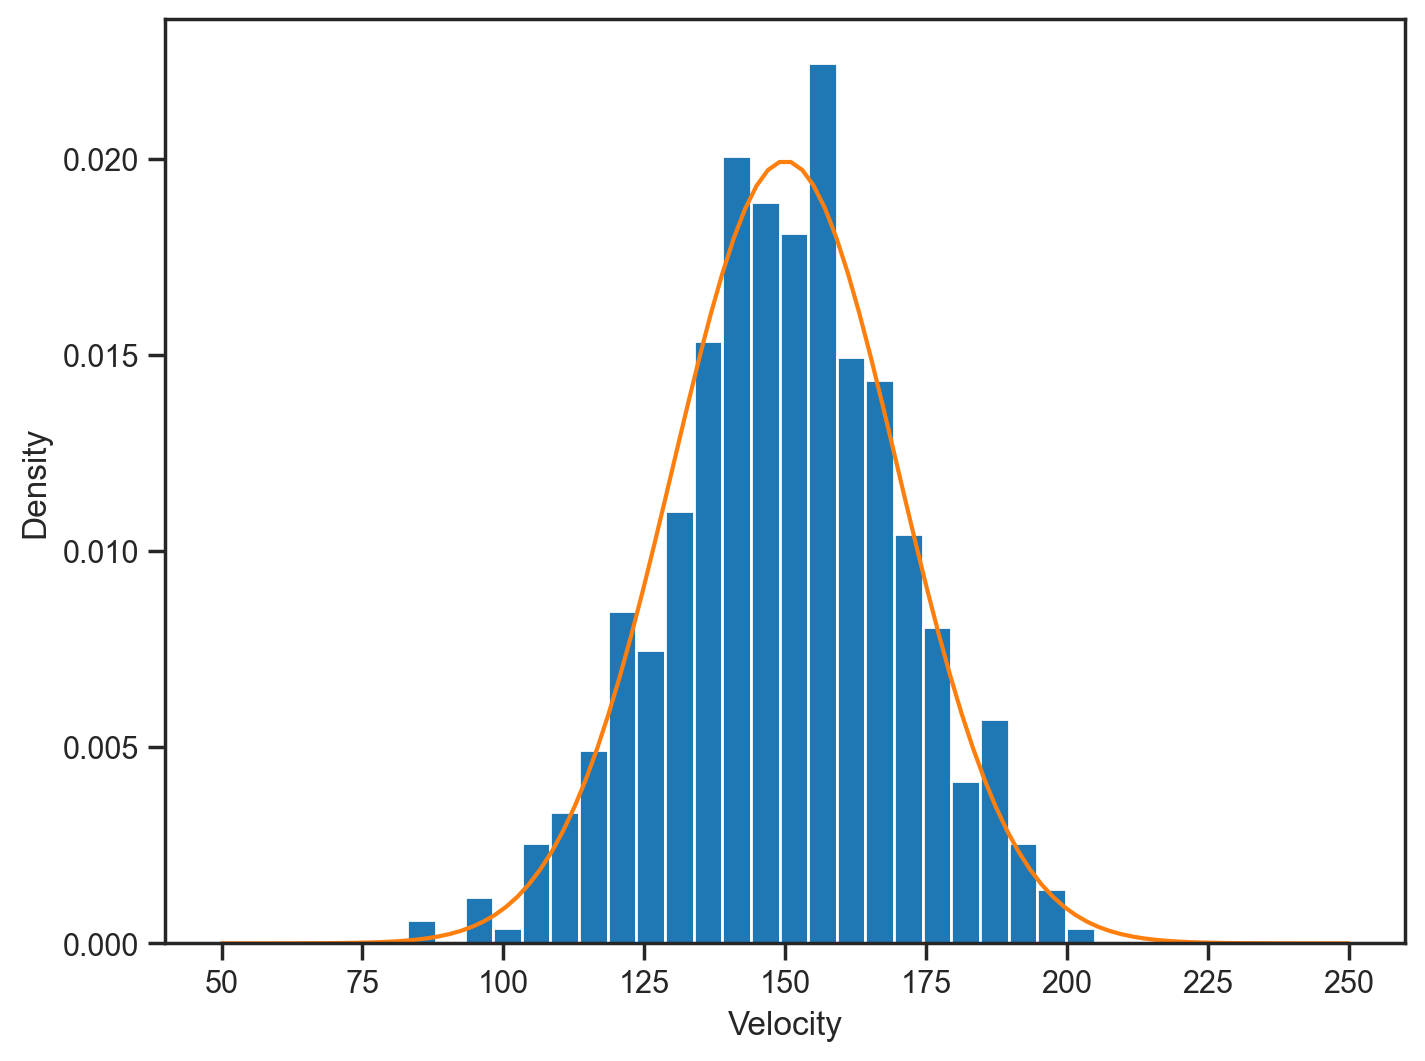

In [77]:
# set up the data for this example


vels = scipy.stats.norm.rvs(loc=150, scale=20, size=1000)

# add some noise, roughly 1 km/s, but not the same for all stars

dvels = scipy.stats.norm.rvs(loc=0, scale=1, size=1000)


vels += dvels

plt.figure()
_, bin_edges = knuth_bin_width(vels, return_bins=True)
plt.hist(vels, bins=bin_edges, density=True)
plt.xlabel("Velocity")
plt.ylabel("Density")

# plot the true distribution
plt.plot(
    np.linspace(50, 250, 100),
    scipy.stats.norm.pdf(np.linspace(50, 250, 100), loc=150, scale=20),
    label="True Distribution",
)

In [78]:
# goal for this example is to fit a Gaussian to the data, accounting for the errors

# so we have just 2 parameters: the mean, the standard deviation


def log_likelihood(params, vels, dvels):
    mean, std = params

    # compute the likelihood of each star
    log_likelihoods = jax.scipy.stats.norm.logpdf(vels, loc=mean, scale=jnp.sqrt(std**2 + dvels**2))

    # return the sum of the likelihoods
    return jnp.sum(log_likelihoods)


def log_prior(params):
    mean, std = params

    return jnp.sum(jax.scipy.stats.uniform.logpdf(
        loc=jnp.array([0, 0]),
        scale=jnp.array([200, 100]),
        x=jnp.array([mean, std]),
    ))

def log_posterior(params, vels, dvels):
    return log_likelihood(params, vels, dvels) + log_prior(params)



In [79]:
# now set up emcee
import emcee

ndim, nwalkers = 2, 100
pos0 = [130, 10] + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(vels,dvels))
_ = sampler.run_mcmc(pos0, 1000, progress=True)


100%|██████████| 1000/1000 [00:37<00:00, 26.32it/s]


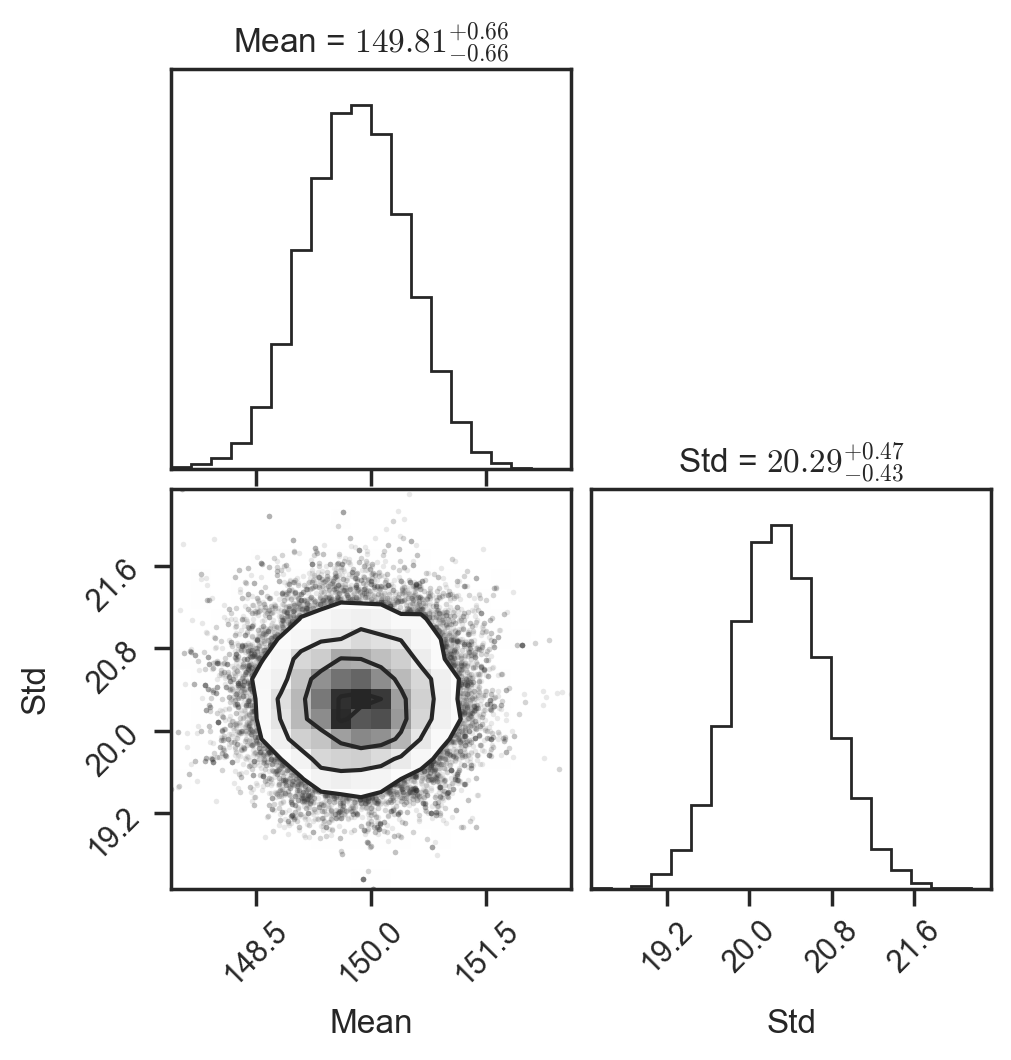

In [80]:
# plot the chains
flat_chain = sampler.get_chain(flat=True, discard=500)

from corner import corner

_ = corner(flat_chain, labels=["Mean", "Std", "Scatter"], show_titles=True)

In [81]:
# this took ~40 seconds to run, not bad but again, would be nice to speed up if this was part of a
# larger pipeline, or if you had to run it many times

In [82]:
# let's try to JIT the log_likelihood function

log_posterior_jax = jax.jit(log_posterior)

# now set up emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_jax, args=(vels,dvels))
_ = sampler.run_mcmc(pos0, 1000, progress=True)


100%|██████████| 1000/1000 [00:02<00:00, 453.85it/s]


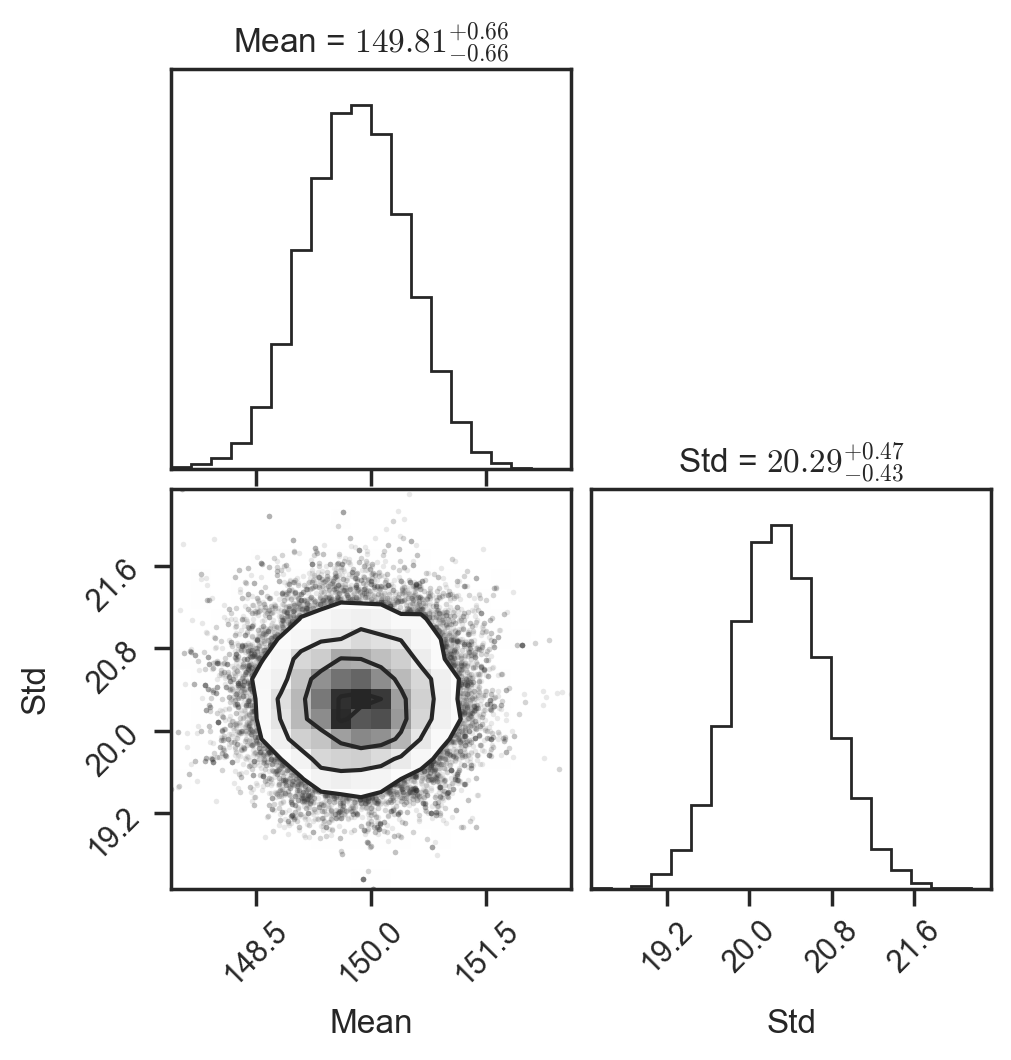

In [84]:
flat_chain = sampler.get_chain(flat=True, discard=500)

_ = corner(flat_chain, labels=["Mean", "Std", "Scatter"], show_titles=True)

In both cases, we get the same (correct) answer, but with the JIT'd version we get a factor of 20 speedup.

# Awkward things that I've hidden from you

Some things that I've hidden in these examples:

- JAX function are usually "pure" functions. This means that they don't modify any state outside of the function. JAX functions will typically return a copy of the input data rather than modifying the input data in place. (You can't reliably print from a JIT'd function, or access global variables, for example.)

- JAX arrays are immutable. You can't directly modify the values of a JAX array. There is however syntactic sugar for updating values in a JAX array, but in non-JIT'd code this is just creating a new array with the updated values.

- We already talked about control flow, which is the thing that requires the most thought when converting code to JAX. There is basically always a way to do what you want, but depending on the complexity of the function, it can be a bit of a pain.

- In JIT'd code, array shapes must be known and static. This means that you can't use JIT with functions that have variable shape inputs or outputs. Usually this is not a problem, but you might need to think about the shapes of your arrays and especially what happens when things go wrong than you would with numpy. No returning zero-dim arrays on errors, no growing arrays to store results, etc.

- JAX can only compute gradients of functions defined in JAX. If you have legacy code that you want to use that calls C or Fortran functions, you cannot use JAX to compute gradients of that code. If you can (somehow?) compute the derivative of this function then you can still integrate this function into your JAX code, but you will have to provide the derivative yourself, and this is not a common occurrence.

In [85]:
arr = jnp.array([1, 2, 3, 4, 5])

arr[3] = 10

TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [86]:
arr.at[3].set(10)


Array([ 1,  2,  3, 10,  5], dtype=int64)

In [87]:
arr

Array([1, 2, 3, 4, 5], dtype=int64)

In [88]:
arr = arr.at[3].set(10)
arr

Array([ 1,  2,  3, 10,  5], dtype=int64)

In [89]:
# some other .at methods
print(arr.at[3].add(5))
print(arr.at[3].mul(2))
print(arr.at[3].max(3))
print(arr.at[3].min(3))

[ 1  2  3 15  5]
[ 1  2  3 20  5]
[ 1  2  3 10  5]
[1 2 3 3 5]


Aren't these copies slower than in-place updates? Yes, they are, but when you JIT a function, these actually get compiled into fast in-place updates. This takes a bit of getting used to, but is typically not a problem in practice.

# Some useful links:

## JAX documentation

- [Installation instructions](https://jax.readthedocs.io/en/latest/installation.html)

- [Quickstart](https://jax.readthedocs.io/en/latest/quickstart.html)

- [Gotchas](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html): Common pitfalls when using JAX.

- [Thinking in JAX](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html)

## Libraries

- [jaxopt](https://jaxopt.github.io/stable/): Optimization routines in JAX. Automatically uses gradient information to speed up optimization.

- [diffrax](https://docs.kidger.site/diffrax/): Differential equation solvers in JAX. Fast, fully compatible with JAX.

- [blackjax](https://github.com/blackjax-devs/blackjax): HMC and NUTS samplers in JAX. Uses JIT and autograd to massively speed up MCMC tasks.

- [numpyro](https://num.pyro.ai/en/stable/): Probabilistic programming in JAX. Similar to PyMC or Stan.

- [tinygp](https://tinygp.readthedocs.io/en/stable/): Gaussian processes in JAX.

- [bayeux](https://jax-ml.github.io/bayeux/): General purpose Bayesian inference in JAX. Provide a JAX-compatible log likelihood function and apply your choice of inference methods, common interface to a variety of MCMC methods, optimizers and variational inference.

- [equinox](https://docs.kidger.site/equinox/): Neural Networks in JAX. Fast, simple, and flexible. Also provides a ton of useful utilities for building and debugging more complicated non-neural network models in JAX. 

- [jaxtyping](https://github.com/patrick-kidger/jaxtyping): Library for type _and array shape_ checking in JAX.

## Astronomy specific stuff

- [galax](https://github.com/GalacticDynamics/galax/): JAX-based successor to Gala. Still in development, but already usable for many tasks.

- [coordinax](https://github.com/GalacticDynamics/coordinax/): Astropy coordinates in JAX.

- [unxt](https://github.com/GalacticDynamics/unxt/): Astropy units in JAX.